In [1]:
# Gerekli kütüphaneleri yükleyin
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import SGD  # SGD optimizer import edildi
from keras import regularizers
from PIL import Image

In [2]:
# Girdi dizini (orijinal dataset)
data_dir_path = 'Alzheimer_s Dataset'

# Çıktı dizini (işlenmiş dataset)
output_dir = 'Processed_Alzheimer_Dataset'

# Görselleri işleyip kaydetme
processed_count = 0
for root, dirs, files in os.walk(data_dir_path):
    for img_file in files:
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(root, img_file)
            try:
                # Görseli aç
                image = Image.open(img_path)

                # Görseli yeniden boyutlandır ve RGB'ye dönüştür
                image = image.resize((224, 224)).convert('RGB')

                # Çıkış yolunu ayarla
                relative_path = os.path.relpath(root, data_dir_path)  # test/train/validation/sınıf
                save_dir = os.path.join(output_dir, relative_path)

                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)

                # Görseli kaydet
                save_path = os.path.join(save_dir, img_file)
                image.save(save_path)

                # İşlenen görsel sayısını artır
                processed_count += 1
            except Exception as e:
                print(f"{img_path} işlenirken bir hata oluştu: {e}")

# İşlenen görsel sayısını yazdır
print(f"Toplam {processed_count} görsel işlenmiştir.")

Toplam 7110 görsel işlenmiştir.


In [3]:
print(image.mode)  # 'L' ise gri tonlama, 'RGB' ise renkli

RGB


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
import numpy as np

# Moderate Demented sınıfı dizini
input_dir = 'Processed_Alzheimer_Dataset/train/ModerateDemented'
output_dir = 'Processed/augmented_moderate_demented'

# Veri artırma ayarları
moderate_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,       # Yatay çevirme tamam
    fill_mode='reflect' 
)

# Yeni görüntüler üretmek
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Her görüntü için veri artırma işlemi
target_count = 1000  # Artırma sonrası hedef görüntü sayısı
current_count = len(os.listdir(input_dir))
images_needed = target_count - current_count

# Her orijinal görüntüden oluşturulacak yeni görüntü sayısı
augment_per_image = images_needed // current_count + 1

# Artırma işlemi
for img_file in os.listdir(input_dir):
    img_path = os.path.join(input_dir, img_file)
    img = load_img(img_path, target_size=(224, 224))  # Görüntüyü yükle ve boyutlandır
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Yeni görüntüler oluştur ve kaydet
    i = 0
    for batch in moderate_datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= augment_per_image:
            break

In [ ]:
import shutil
import os

# Artırılmış görüntülerin bulunduğu dizin
augmented_data_dir = 'Processed/augmented_moderate_demented'

# Eğitim verilerinin hedef dizini
train_dir = 'Processed_Alzheimer_Dataset/train/ModerateDemented/'

# Artırılmış görüntüleri taşı
for img_file in os.listdir(augmented_data_dir):
    src_path = os.path.join(augmented_data_dir, img_file)
    dst_path = os.path.join(train_dir, img_file)
    shutil.move(src_path, dst_path)


In [4]:
# Eğitim, doğrulama ve test dizinlerinin yolu
train_dir = 'Processed_Alzheimer_Dataset/train'
val_dir = 'Processed_Alzheimer_Dataset/validation'
test_dir = 'Processed_Alzheimer_Dataset/test'

# Eğitim verisi artırma
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalizasyon
    #rotation_range=40,            # Dönme
    #width_shift_range=0.3,        # Yatay kaydırma
    #height_shift_range=0.3,       # Dikey kaydırma
    #shear_range=0.3,             # Kesme
    #zoom_range=0.3,              # Yakınlaştırma
    #horizontal_flip=True,         # Yatay çevirme
    #fill_mode='nearest'           # Eksik pikselleri doldurma
)

# Doğrulama ve test için yalnızca normalizasyon
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Eğitim verilerini yükleme
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),       # Görüntü boyutu
    batch_size=32,               # Mini-batch boyutu
    class_mode='categorical',    # Kategorik sınıflandırma
    color_mode='rgb'             # 3 kanal
)

# Doğrulama verilerini yükleme
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

# Test verilerini yükleme
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

Found 4676 images belonging to 4 classes.
Found 2086 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# ResNet50 modelini önceden eğitilmiş ağırlıklarıyla yükle
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ResNet50'nin son 10 katmanını serbest bırak
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Modeli oluştur
model = Sequential()

# ResNet50'yi ekle (özellik çıkarıcı olarak)
model.add(base_model)

# Global average pooling katmanı
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization()) 
model.add(Flatten()) # Flatten ekliyor

# Tam bağlantılı (Dense) katmanlar
model.add(Dense(512, activation='relu'))  # Daha fazla nöron
model.add(BatchNormalization()) 
model.add(Dropout(0.5))                    # Aşırı öğrenmeyi engellemek için daha yüksek dropout oranı

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization()) 
model.add(Dropout(0.5))

# Çıkış katmanı (4 sınıf için)
model.add(Dense(4, activation='softmax'))

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model özeti
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,713,732 (94.28 MB)

 Trainable params: 5,586,308 (21.31 MB)

 Non-trainable params: 19,127,424 (72.97 MB)

In [6]:
# Erken durdurma
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli eğit
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping]
)

C:\Users\beyza\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.4644 - loss: 1.6084 - val_accuracy: 0.4463 - val_loss: 1.4247
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.6071 - loss: 1.1159 - val_accuracy: 0.4463 - val_loss: 1.2207
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.6607 - loss: 0.9484 - val_accuracy: 0.3725 - val_loss: 1.2419
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.6709 - loss: 0.8699 - val_accuracy: 0.5484 - val_loss: 0.9921
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.7219 - loss: 0.7216 - val_accuracy: 0.4046 - val_loss: 2.6557
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.7248 - loss: 0.7027 - val_accuracy: 0.4645 - val_loss: 1.9152
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.7505 - loss: 0.6440 - val_accuracy: 0.4343 - val_loss: 1.9155
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.7794 - loss: 0.5558 - val_accu

In [7]:
# Test seti üzerinde modelin doğruluğunu test et
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4972 - loss: 1.2092
Test Loss: 1.2283467054367065
Test Accuracy: 0.4925723075866699


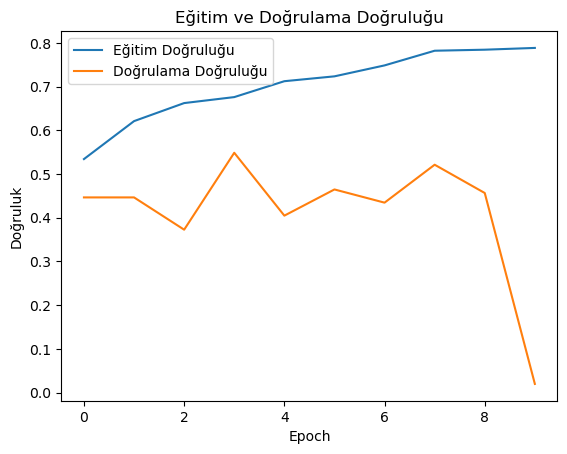

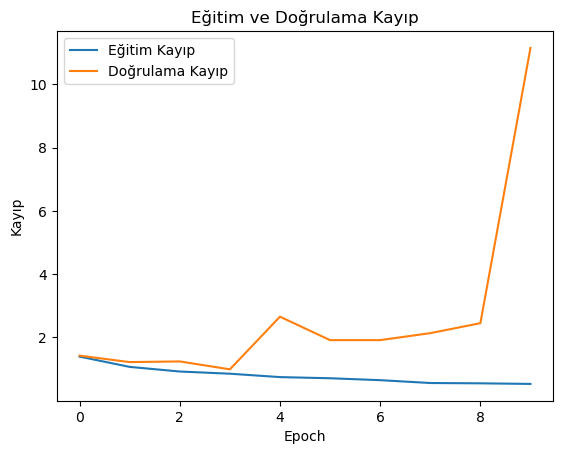

In [8]:
import matplotlib.pyplot as plt

# Eğitim sürecindeki doğruluk ve kayıp değerlerini görselleştirme
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Eğitim Kayıp')
plt.plot(history.history['val_loss'], label='Doğrulama Kayıp')
plt.title('Eğitim ve Doğrulama Kayıp')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step 


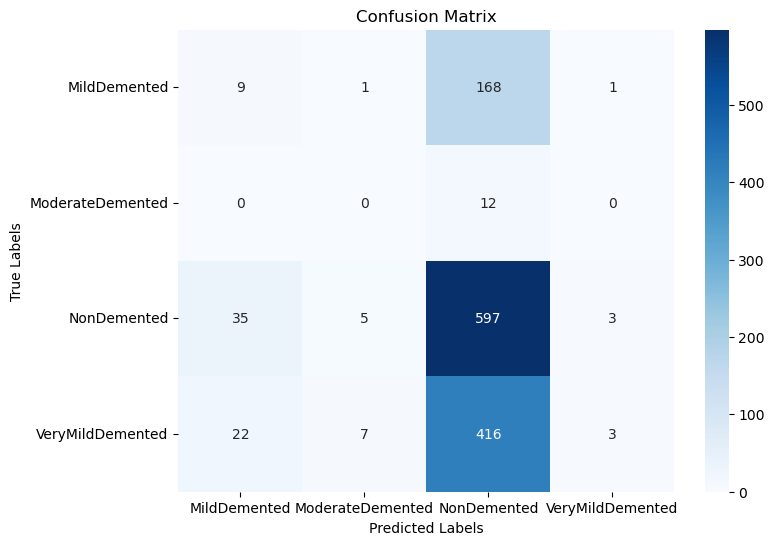

Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.14      0.05      0.07       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.50      0.93      0.65       640
VeryMildDemented       0.43      0.01      0.01       448

        accuracy                           0.48      1279
       macro avg       0.27      0.25      0.18      1279
    weighted avg       0.42      0.48      0.34      1279



In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Test setindeki gerçek etiketler ve tahmin edilen etiketler
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Konfüzyon matrisi
cm = confusion_matrix(true_labels, predicted_labels)

# Sınıf isimlerini alma
class_names = list(test_generator.class_indices.keys())

# Konfüzyon matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Sınıflandırma raporu
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n")
print(report)

In [ ]:
model.save_weights("model_weights.weights.h5")